Writeup: This project was built off a very barebones model I had built prior for the problem that performed poorly and had just a few cells of data visualization and preprocessing. In this project I significantly upgraded the preprocessing strategies and visualizations, as well as improving my feature engineering methods, model construction and hyperparameter tuning. 

The problem I decided to attempt to predict the amount of retweets a particular tweet would receive based on its content and when it was posted. Two models were used here - a k nearest regressor and a feed-forward neural network. Alternative regressors such as support vector, Random Forest and Gaussian process were also attempted and played with, but ended up being unable to train in any reasonable amount of time. The final MAE for both models stood at around 6,000. For reference, a completely uninformed model stood at an MAE of about 20,000.

To simplify the dataset and focus on the relevant features for predicting the
number of retweets, the columns 'id', 'link', 'geo', 'favorites', and 'hashtags were
dropped'. The reasoning was that the number of favorites in a tweet could potentially
reflect the number of retweets and, therefore, should not be included as features. There
is a direct correlation between the number of retweets and the number of favorites a
tweet has gotten since they both cause the popularity of the tweet. The number of
hashtags were considered, however it was deemed that they would not affect tweets
enough and could be unnecessary noise.

Furthermore, the 'date' column was dropped and from it two new columns, 'hour'
and 'month' were extracted. The ‘month column was added to the dataset to capture
any seasonal trends that might affect the number of retweets a tweet would receive.
Since there is a similar idea with posting on Instagram at certain times to get the most
likes these models would see if there was a time relation hence the ‘hour’ column was
added.

The number of @s a tweet had could also be thought to affect the popularity of a
tweet. To see if tagging others in a tweet would affect the number of retweets, this
feature was included. Preprocessing was required to cleanse this feature and substitute
null/invalid values with their intended representation.

In addition to dropping unnecessary columns and extracting new features, I
also preprocessed the dataset by removing outliers and considering additional features.
Specifically, we removed all tweets with less than 25 retweets and all tweets with more
than 75,000 retweets. This was done to prevent extreme values from skewing the
analysis and to focus on tweets that had a more typical level of engagement.

Sentiment analysis was also conducted and used as a feature for each tweet using Textblob. A tokenizer specifically constructed to work with tweets was also selected as opposted to typical word tokenizers, and basic stopword and punctuation data cleansing was also applied.

We then experimented with multiple hyperparamter tunings for the FFNN, eventually noticing that a 256 and 128 neuron layered model worked merginally better than the others, with dropout layers in between.

# Additions

Everything I developed in addition to the base model:
- Modifying sample size & experimenting with it to find a good balance between quantity and efficiency for hyperparameter tuning
- Developing Proper noun recognition
    - Before, any words not recognized by the word embedding model were just ignored and not used at all. 
    - Now, each time a proper noun is detected, it is recorded in a proper noun dictionary as a unique 300 length vector
    - It is represented as that vector each time it appears. Used NLTK Part of speech tagging to achieve this.
    - Modified vectorization function to account for above change as well
- Text preprocessing function had to be modified as well and was split from the vectorization application in order to apply functions to the text before it was vectorized, but after it was cleaned by the preprocessing function
- Engineered two new features - links and sentiment score
    - For links, I counted the number of links that appeared in the string representation of the tweet and recorded it
    - For sentiment score, I experimented with building my own sentiment analysis model and training it on one of the many existing kaggle datasets that would permit me to do so, but decided against it because TextBlob, a NLP library had a module that already contained this functionality. Furthermore, my sentiment analysis attempts had run intoa  few roadblocks which I realized would take some time to get around - time I didn't need to spend because I had the functionality I needed already in that module. The module's polarity function generates a number on a scale from -1 to 1 that determines how positive or negative a tweet is, and the degree of extremity.
    - Also experimented with counting the number of positive and negative connotated words in the tweet, using preconstructed lists of words that we know for sure are positiev and negative, but this was also scrapped in favor of the above module
    - The two attempts described in the bullets above are not included here, as this is all just the code that was used in the final product, and those past attempts were thrown away.
- After counting links, removed all URLs and digits from each tweet with the re/replace function
- Switched from using the typical word tokenizer provided by NLTK to their twitter-specific one that was built to tokenize tweets and to handle the anomalies that come with them
- Also using a tweet preprocessor module that removed much of the noise and incomprehensible characters from each tweet. Applied this alongside the vectorization function in the same apply statement.
- Train and testing process was fixed, and the method of adding the engineered features to the test and training sets was completely revamped - previously had just assigned new columns to the existing ones, but switched over to using the pandas join function which prevented the creation of a bunch fo dummy features with all NaN values as the previous method had. Also reset indices to ensure the shapes lined up.
- Experimented with many different hyperparameter combinations for the forward-feeding neural network, from activation functions to layer structure and order, as well as the inclusion of dropout layers.
- When having enough neurons, generally solid performance, but some stood out. 
- Analyzed performance of all tests and produced a final model and trained it for an additional 15 epochs to evaluate its performance.
- Did this same process for the KNr method.

In [67]:
import pandas as pd
import numpy as np
import matplotlib as mlt
import re
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import copy
import math
import matplotlib.pyplot as plt

from gensim import models
from nltk.tokenize import TweetTokenizer
import preprocessor as p



In [45]:
#Loads in pre-trained Word2Vec word embedding model
#Plots words on a 300-dimensional space, placing connected words close by
w2v = models.KeyedVectors.load_word2vec_format('vec.gz', binary=True)

In [46]:
#Read data and drop irrelvant features
df = pd.read_csv('trumptweets.csv')
df.drop('id', axis=1, inplace=True)
df.drop('link', axis=1, inplace=True)
df.drop('geo', axis=1, inplace=True)
df.drop('favorites', axis=1, inplace=True)
df.drop('hashtags', axis=1, inplace=True)

#Take most recent 6,000 tweets to increase training speed for hyperparameter tuning
df = df.tail(6000)

df

,content,date,retweets,mentions
35122,I will be interviewed on @ foxandfriends by @ ...,2018-08-23 02:51:38,9311,@ @
35123,The only thing that I have done wrong is to wi...,2018-08-23 02:56:35,32321,NaN
35124,I have asked Secretary of State @ SecPompeo to...,2018-08-23 04:28:45,38439,@ @ @
35125,NO COLLUSION - RIGGED WITCH HUNT!,2018-08-23 07:10:08,23523,NaN
35126,pic.twitter.com/3PAVDdfJJr,2018-08-23 15:44:47,12026,NaN
...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,NaN
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,NaN
41119,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,NaN
41120,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,@ @ @


In [47]:
lemmatizer = WordNetLemmatizer()
corpus = ' '.join(df['content'])

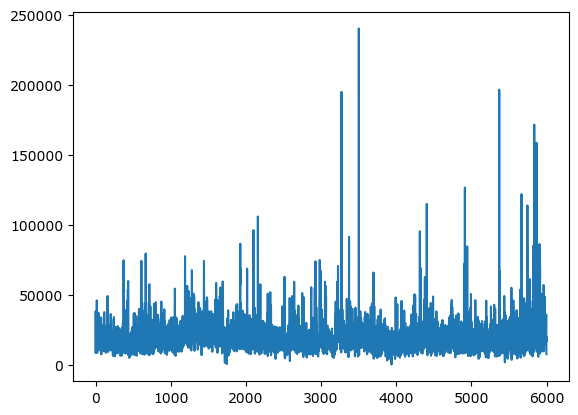

In [48]:
#Data spread before pruning of outliers
plt.plot([i for i in range(len(df['retweets']))], list(df['retweets']))
plt.show()

In [49]:
df = df[df['retweets'] >= 25]
df = df[df['retweets'] <= 75000]

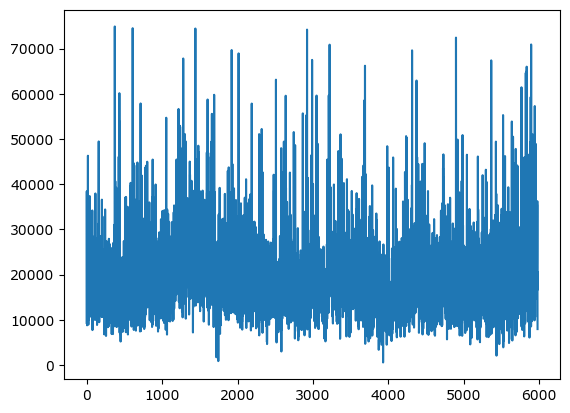

In [50]:
#Data spread post outlier removal
plt.plot([i for i in range(len(df['retweets']))], list(df['retweets']))
plt.show()

In [51]:
#Cleaning mentions column to eliminate all null values
df['mentions'] = df['mentions'].fillna(0)
df['mentions'] = df['mentions'].apply(lambda x : x.count('@') if x != 0 else 0)

In [52]:
df['month'] = df['date'].apply(lambda x : int(x[5:7]))
df['hour'] = df['date'].apply(lambda x : int(x[11:13]))
df.drop('date', axis=1, inplace=True)

In [53]:
def is_proper_noun(s):
    tokens = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(tokens)
    for tag in tagged:
        if tag[1] == 'NNP':
            return True
    return False

In [54]:
import random
import re


#Vectorizes all words in the array and then flattens 2D array into 1D Numpy array
def vectorize(words):
    proper_nouns = dict()
    vectors = np.array([])
    
    for word in words:
        if word in w2v.key_to_index.keys():
            vectors = np.concatenate((vectors, w2v[word]))
        elif is_proper_noun(word):
            if word not in proper_nouns.keys():
                vec = [random.randint(50, 99) for _ in range(300)]
                vectors = np.concatenate((vectors, vec))
                proper_nouns[word] = vec
            else:
                vectors = np.concatenate((vectors, proper_nouns[word]))
    
    if len(vectors) == 0:
        return None
    else: 
        return vectors

#Preprocessing function applied to every tweet to prepare it for entry into the ANN
def preprocess_text(text):
    text = re.compile(r'https?://\S+').sub('', text)
    
    tokens = TweetTokenizer().tokenize(text)
    
    for i in range(len(tokens) - 1, -1, -1):
        token = tokens[i]
        
        if token in stopwords.words('english') or token in string.punctuation or len(token) < 3:
            tokens.pop(i)
        else:
            tokens[i] = lemmatizer.lemmatize(token).lower().replace('\d+', '')
            
    if len(tokens) == 0:
        return None
    else:  
        return ' '.join(tokens)


In [55]:
from textblob import TextBlob

In [56]:
df['links'] = df['content'].apply(lambda x : x.count('https'))

df['sentiment_score'] = df['content'].apply(lambda x : TextBlob(p.clean(x)).sentiment.polarity)
                                                         
df['content'] = df['content'].apply(lambda x : preprocess_text(p.clean(x)))
df.dropna(inplace=True)

df

,content,retweets,mentions,month,hour,links,sentiment_score
35122,interviewed foxandfriends ainsleyearhardt tomo...,9311,2,8,2,0,0.500000
35123,the thing done wrong win election expected cro...,32321,0,8,2,0,0.033333
35124,asked secretary state secpompeo closely study ...,38439,3,8,4,0,0.041071
35125,collusion rigged witch hunt,23523,0,8,7,0,0.000000
35129,great honor host foreign investment risk revie...,9439,1,8,20,0,0.321875
...,...,...,...,...,...,...,...
41117,never seen republican party strong unified rig...,32620,0,1,19,0,0.395238
41118,now mini mike bloomberg critical jack wilson s...,36239,0,1,22,0,-0.275000
41119,thrilled back great state texas tonight people...,16588,0,1,1,1,0.396825
41120,house president got le due process terrorist g...,20599,3,1,2,0,-0.116667


In [57]:
df['content'] = df['content'].apply(lambda x : vectorize(x))
df

,content,retweets,mentions,month,hour,links,sentiment_score
35122,"[-0.2255859375, -0.01953125, 0.0908203125, 0.2...",9311,2,8,2,0,0.500000
35123,"[-0.337890625, 0.1982421875, -0.296875, 0.1484...",32321,0,8,2,0,0.033333
35124,"[-0.291015625, 0.1787109375, 0.050048828125, 0...",38439,3,8,4,0,0.041071
35125,"[-0.2080078125, 0.0341796875, 0.0257568359375,...",23523,0,8,7,0,0.000000
35129,"[-0.388671875, -0.01287841796875, 0.15234375, ...",9439,1,8,20,0,0.321875
...,...,...,...,...,...,...,...
41117,"[-0.01397705078125, -0.0272216796875, -0.05493...",32620,0,1,19,0,0.395238
41118,"[-0.01397705078125, -0.0272216796875, -0.05493...",36239,0,1,22,0,-0.275000
41119,"[-0.337890625, 0.1982421875, -0.296875, 0.1484...",16588,0,1,1,1,0.396825
41120,"[-0.287109375, 0.29296875, -0.044677734375, 0....",20599,3,1,2,0,-0.116667


In [58]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)

# specify the features and target columns
X = df['content']
y = df['retweets']

max_length = max(len(row) for row in np.array(X))

# Pad shorter rows with 0s
X = pd.DataFrame(np.array([np.pad(row, (0, max_length - len(row)), 'constant') for row in X]))

df.reset_index(drop=True, inplace=True)
X = X.join(df['mentions'])
X = X.join(df['month'])
X = X.join(df['hour'])
X = X.join(df['links'])

X = X.join(df['sentiment_score'])

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X

,0,1,2,3,4,5,6,7,8,9,...,56995,56996,56997,56998,56999,mentions,month,hour,links,sentiment_score
0,-0.225586,-0.019531,0.090820,0.237305,-0.029297,0.093262,-0.058838,-0.041016,0.052246,0.020020,...,0.0,0.0,0.0,0.0,0.0,2,8,2,0,0.500000
1,-0.337891,0.198242,-0.296875,0.148438,-0.217773,-0.036865,-0.005829,-0.121094,0.142578,-0.050537,...,0.0,0.0,0.0,0.0,0.0,0,8,2,0,0.033333
2,-0.291016,0.178711,0.050049,0.098145,0.026245,-0.107422,0.051270,-0.056641,0.057617,-0.083984,...,0.0,0.0,0.0,0.0,0.0,3,8,4,0,0.041071
3,-0.208008,0.034180,0.025757,0.179688,-0.181641,-0.034180,-0.140625,-0.163086,-0.085938,-0.152344,...,0.0,0.0,0.0,0.0,0.0,0,8,7,0,0.000000
4,-0.388672,-0.012878,0.152344,0.160156,-0.111328,-0.006683,-0.083008,-0.154297,-0.173828,-0.031494,...,0.0,0.0,0.0,0.0,0.0,1,8,20,0,0.321875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631,-0.013977,-0.027222,-0.054932,0.175781,-0.178711,0.083984,0.062988,0.048828,-0.125000,0.143555,...,0.0,0.0,0.0,0.0,0.0,0,1,19,0,0.395238
5632,-0.013977,-0.027222,-0.054932,0.175781,-0.178711,0.083984,0.062988,0.048828,-0.125000,0.143555,...,0.0,0.0,0.0,0.0,0.0,0,1,22,0,-0.275000
5633,-0.337891,0.198242,-0.296875,0.148438,-0.217773,-0.036865,-0.005829,-0.121094,0.142578,-0.050537,...,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0.396825
5634,-0.287109,0.292969,-0.044678,0.038330,-0.144531,-0.048096,-0.251953,-0.113281,-0.011780,0.082520,...,0.0,0.0,0.0,0.0,0.0,3,1,2,0,-0.116667


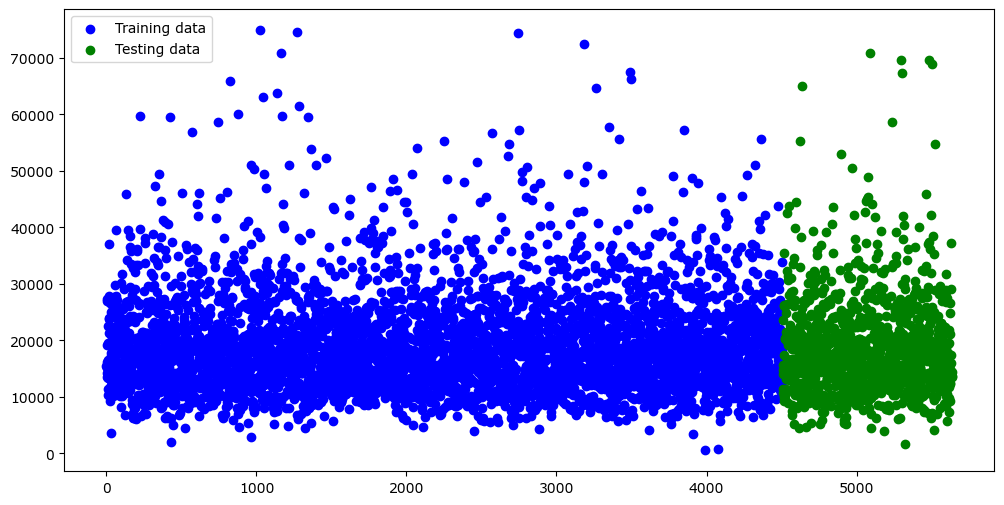

In [59]:
#Plotting all training and test data
plt.figure( figsize = (12,6))
plt.scatter([i for i in range(len(y_train))], y_train, c='b', label = 'Training data')
plt.scatter([len(y_train) + i for i in range(len(y_test))], y_test, c='g', label='Testing data')
plt.legend()

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#Model creation
model = Sequential()
 
model.add(Dense(units=256, input_dim=len(X_train.iloc[0]), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
 

model.compile(loss='mean_absolute_error', optimizer='adam')

#Fitting model on training datasets
model.fit(np.array(X_train.values), np.array(y_train.values), batch_size = 20, epochs = 10, verbose=1)

predictions = model.predict(X_test)

#Compute MAE from predictions & actual values
MAE = [abs(list(predictions)[i] - list(y_test)[i]) for i in range(len(predictions))]

MAE = sum(MAE) / len(MAE)
MAE

Epoch 1/10
226/226 [==============================] - 15s 58ms/step - loss: 9748.5576
Epoch 2/10
226/226 [==============================] - 13s 56ms/step - loss: 6303.6758
Epoch 3/10
226/226 [==============================] - 12s 55ms/step - loss: 6066.7065
Epoch 4/10
226/226 [==============================] - 12s 54ms/step - loss: 5866.2207
Epoch 5/10
226/226 [==============================] - 12s 54ms/step - loss: 5739.7598
Epoch 6/10
226/226 [==============================] - 13s 57ms/step - loss: 5529.9043
Epoch 7/10
226/226 [==============================] - 13s 56ms/step - loss: 5353.4233
Epoch 8/10
226/226 [==============================] - 13s 56ms/step - loss: 5127.5269
Epoch 9/10
226/226 [==============================] - 12s 55ms/step - loss: 5031.0381
Epoch 10/10
36/36 [==============================] - 1s 13ms/step


array([6006.1974734])

In [61]:
#Model creation
model = Sequential()
 
model.add(Dense(units=512, input_dim=len(X_train.iloc[0]), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
 

model.compile(loss='mean_absolute_error', optimizer='adam')

#Fitting model on training datasets
model.fit(np.array(X_train.values), np.array(y_train.values), batch_size = 20, epochs = 10, verbose=1)

predictions = model.predict(X_test)

#Compute MAE from predictions & actual values
MAE = [abs(list(predictions)[i] - list(y_test)[i]) for i in range(len(predictions))]

MAE = sum(MAE) / len(MAE)
MAE

Epoch 1/10
226/226 [==============================] - 23s 96ms/step - loss: 8663.3545
Epoch 2/10
226/226 [==============================] - 23s 100ms/step - loss: 6061.8657
Epoch 3/10
226/226 [==============================] - 26s 115ms/step - loss: 5833.2495
Epoch 4/10
226/226 [==============================] - 24s 107ms/step - loss: 5561.4248
Epoch 5/10
226/226 [==============================] - 26s 115ms/step - loss: 5349.1133
Epoch 6/10
226/226 [==============================] - 24s 104ms/step - loss: 5083.2578
Epoch 7/10
226/226 [==============================] - 21s 95ms/step - loss: 4828.3062
Epoch 8/10
226/226 [==============================] - 22s 98ms/step - loss: 4658.2090
Epoch 9/10
226/226 [==============================] - 22s 96ms/step - loss: 4460.1924
Epoch 10/10
36/36 [==============================] - 1s 24ms/step


array([6231.2794934])

In [62]:
#Model creation
model = Sequential()
 
model.add(Dense(units=64, input_dim=len(X_train.iloc[0]), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
 

model.compile(loss='mean_absolute_error', optimizer='adam')

#Fitting model on training datasets
model.fit(np.array(X_train.values), np.array(y_train.values), batch_size = 20, epochs = 10, verbose=1)

predictions = model.predict(X_test)

#Compute MAE from predictions & actual values
MAE = [abs(list(predictions)[i] - list(y_test)[i]) for i in range(len(predictions))]

MAE = sum(MAE) / len(MAE)
MAE

Epoch 1/10
226/226 [==============================] - 4s 15ms/step - loss: 14360.8691
Epoch 2/10
226/226 [==============================] - 4s 17ms/step - loss: 7910.1348
Epoch 3/10
226/226 [==============================] - 4s 17ms/step - loss: 7310.9336
Epoch 4/10
226/226 [==============================] - 4s 17ms/step - loss: 6958.1812
Epoch 5/10
226/226 [==============================] - 4s 17ms/step - loss: 6810.2148
Epoch 6/10
226/226 [==============================] - 4s 19ms/step - loss: 6733.6885
Epoch 7/10
226/226 [==============================] - 4s 19ms/step - loss: 6597.3281
Epoch 8/10
226/226 [==============================] - 4s 19ms/step - loss: 6491.0781
Epoch 9/10
226/226 [==============================] - 4s 17ms/step - loss: 6442.0288
Epoch 10/10
36/36 [==============================] - 0s 7ms/step


array([6108.18858262])

In [63]:
#Model creation
model = Sequential()
 
model.add(Dense(units=512, input_dim=len(X_train.iloc[0]), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
 

model.compile(loss='mean_absolute_error', optimizer='adam')

#Fitting model on training datasets
model.fit(np.array(X_train.values), np.array(y_train.values), batch_size = 20, epochs = 10, verbose=1)

predictions = model.predict(X_test)

#Compute MAE from predictions & actual values
MAE = [abs(list(predictions)[i] - list(y_test)[i]) for i in range(len(predictions))]

MAE = sum(MAE) / len(MAE)
MAE

Epoch 1/10
226/226 [==============================] - 24s 100ms/step - loss: 8346.9268
Epoch 2/10
226/226 [==============================] - 22s 99ms/step - loss: 5990.1143
Epoch 3/10
226/226 [==============================] - 24s 107ms/step - loss: 5753.4634
Epoch 4/10
226/226 [==============================] - 22s 96ms/step - loss: 5419.3418
Epoch 5/10
226/226 [==============================] - 22s 97ms/step - loss: 5156.0952
Epoch 6/10
226/226 [==============================] - 22s 97ms/step - loss: 4859.6943
Epoch 7/10
226/226 [==============================] - 21s 95ms/step - loss: 4558.8623
Epoch 8/10
226/226 [==============================] - 22s 98ms/step - loss: 4407.6802
Epoch 9/10
226/226 [==============================] - 22s 98ms/step - loss: 4201.7314
Epoch 10/10
36/36 [==============================] - 1s 19ms/step


array([6183.63936923])

Below is the best model that produced the best MAE, trained for extra epochs

In [64]:
#Model creation
model = Sequential()
 
model.add(Dense(units=512, input_dim=len(X_train.iloc[0]), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
 

model.compile(loss='mean_absolute_error', optimizer='adam')

#Fitting model on training datasets
model.fit(np.array(X_train.values), np.array(y_train.values), batch_size = 20, epochs = 25, verbose=1)

predictions = model.predict(X_test)

#Compute MAE from predictions & actual values
MAE = [abs(list(predictions)[i] - list(y_test)[i]) for i in range(len(predictions))]

MAE = sum(MAE) / len(MAE)
MAE

Epoch 1/25
226/226 [==============================] - 22s 96ms/step - loss: 8352.5605
Epoch 2/25
226/226 [==============================] - 22s 95ms/step - loss: 6006.0454
Epoch 3/25
226/226 [==============================] - 22s 97ms/step - loss: 5742.3599
Epoch 4/25
226/226 [==============================] - 22s 99ms/step - loss: 5462.7104
Epoch 5/25
226/226 [==============================] - 21s 93ms/step - loss: 5095.5234
Epoch 6/25
226/226 [==============================] - 21s 94ms/step - loss: 4806.3867
Epoch 7/25
226/226 [==============================] - 21s 94ms/step - loss: 4599.6587
Epoch 8/25
226/226 [==============================] - 21s 94ms/step - loss: 4399.1597
Epoch 9/25
226/226 [==============================] - 21s 93ms/step - loss: 4179.7432
Epoch 10/25
226/226 [==============================] - 21s 93ms/step - loss: 4042.6128
Epoch 11/25
226/226 [==============================] - 21s 94ms/step - loss: 3850.3350
Epoch 12/25
226/226 [==============================]

array([6709.89930628])

Extra training seems to have overfit the model despite the dropout layers, as MAE is higher with more epochs

# KNr approach

In [65]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR

In [66]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train a KNN regressor
k = 20
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
# Evaluate the model on the test set
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

MAE: 5848.96, RMSE: 8562.24


In [68]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train a KNN regressor
k = 7
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
# Evaluate the model on the test set
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

MAE: 6353.67, RMSE: 8953.34


In [69]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train a KNN regressor
k = 50
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
# Evaluate the model on the test set
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

MAE: 5842.34, RMSE: 8619.15


In [70]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train a KNN regressor
k = 100
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
# Evaluate the model on the test set
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

MAE: 5903.61, RMSE: 8703.54
